# Project Report
Li Chang, [Udacity Machine Learning](www.udacity.com/course/ud120) Final Project

## Background
Enron Corporation, one of the largest American companies in history, bankruped after its share price plummeted from ~91 US dollars in 2000 to just pennies in late 2011. The concequences of Enron's bankrupcy was catastrophic: nearly 20,000 staff lost jobs, stock market crashed at the wake of the Enron scandal, and millions of investors lost their pension funds. Although Enron's fall is largely due to the misleading accounting practices and fabricated numbers, the root cause is largely because of its people - the negligence of the senior management and the misconduct of the traders on the floor. 

This project aims to examine Enron dataset, explore the relationship between various Enron's stakeholders, and produce a machine learning classifier to identify whether he or she is a person of interest(POI). A [POI](https://www.udacity.com/course/viewer#!/c-ud120/l-2291728537/m-2473678541) is defined as someone who got indicted, settled without admitting guilt or testified in exchange for immunity. 

##1. Dataset
###1.1 Data Exploration
This dataset has a total of 146 records, each containing 21 variables of which 14 are financial features, 6 are email features and 1 is labelling variable(POI). 

In [1]:
#Import packages
from feature_format import featureFormat, targetFeatureSplit
from tester import test_classifier, dump_classifier_and_data

import pickle
import numpy as np
import operator
import pprint as pp
import time
%matplotlib inline
import matplotlib.pyplot as plt

import pandas as pd
from scipy.stats import describe
from sklearn import preprocessing

from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier


from sklearn.learning_curve import learning_curve
from sklearn import cross_validation
from sklearn.cross_validation import StratifiedShuffleSplit
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from __future__ import print_function

In [2]:
### Load the dictionary containing the dataset
data_dict = pickle.load(open("final_project_dataset.pkl", "r") )

### Provide basic information
records = len(data_dict)
print("Number of records: %i" % records)

number_keys = len(data_dict.values()[0].keys())
print("Number of variables: %i" % number_keys)

poi = 0
for person in data_dict.values(): 
    if person["poi"]:
        poi +=1
print("Number of POIs: %i" % poi)

### Print an example
print("An example:")
pp.pprint(data_dict.items()[0])

Number of records: 146
Number of variables: 21
Number of POIs: 18
An example:
('METTS MARK',
 {'bonus': 600000,
  'deferral_payments': 'NaN',
  'deferred_income': 'NaN',
  'director_fees': 'NaN',
  'email_address': 'mark.metts@enron.com',
  'exercised_stock_options': 'NaN',
  'expenses': 94299,
  'from_messages': 29,
  'from_poi_to_this_person': 38,
  'from_this_person_to_poi': 1,
  'loan_advances': 'NaN',
  'long_term_incentive': 'NaN',
  'other': 1740,
  'poi': False,
  'restricted_stock': 585062,
  'restricted_stock_deferred': 'NaN',
  'salary': 365788,
  'shared_receipt_with_poi': 702,
  'to_messages': 807,
  'total_payments': 1061827,
  'total_stock_value': 585062})


### 1.2 Outliers Investigation
After eye-balling these records, I decided to take the following actions: 
* Removed 'THE TRAVEL AGENCY IN THE PARK' - Even if this "agency" did receive a significant amount of payments from Enron, it's simply a third-party service provider, thereof, irrelevant for my investigation. 
* Removed 'Total' - Obviously, this record is meaningless because it's just an aggragtate of all the numbers. 
* Removed 'LOCKHART EUGENE E' - This record does not contain any value and was therefore removed. 

In [3]:
### Remove outliers
removed = ['THE TRAVEL AGENCY IN THE PARK', 'TOTAL', 'LOCKHART EUGENE E']
pp.pprint(data_dict['THE TRAVEL AGENCY IN THE PARK'])
pp.pprint(data_dict['TOTAL'])
pp.pprint(data_dict['LOCKHART EUGENE E'])

for name in removed:
    print("Removed: %s" %name)
    pp.pprint(data_dict[name])
    data_dict.pop(name)

{'bonus': 'NaN',
 'deferral_payments': 'NaN',
 'deferred_income': 'NaN',
 'director_fees': 'NaN',
 'email_address': 'NaN',
 'exercised_stock_options': 'NaN',
 'expenses': 'NaN',
 'from_messages': 'NaN',
 'from_poi_to_this_person': 'NaN',
 'from_this_person_to_poi': 'NaN',
 'loan_advances': 'NaN',
 'long_term_incentive': 'NaN',
 'other': 362096,
 'poi': False,
 'restricted_stock': 'NaN',
 'restricted_stock_deferred': 'NaN',
 'salary': 'NaN',
 'shared_receipt_with_poi': 'NaN',
 'to_messages': 'NaN',
 'total_payments': 362096,
 'total_stock_value': 'NaN'}
{'bonus': 97343619,
 'deferral_payments': 32083396,
 'deferred_income': -27992891,
 'director_fees': 1398517,
 'email_address': 'NaN',
 'exercised_stock_options': 311764000,
 'expenses': 5235198,
 'from_messages': 'NaN',
 'from_poi_to_this_person': 'NaN',
 'from_this_person_to_poi': 'NaN',
 'loan_advances': 83925000,
 'long_term_incentive': 48521928,
 'other': 42667589,
 'poi': False,
 'restricted_stock': 130322299,
 'restricted_stock_de

##2. Optimize Feature Selection/Engineering
###2.1 Create new features
I created some ratio features, for example, by dividing bonus, fees, and stock options by salary or total stock values. I believe a person's compensation should be proportionate to his/her salary. Any exorbitantly high ratio is likely to redflag something fishy.
* Bonus as a share of salary: 'bonus'/'salary'
* Total stock vlaue as compared to salary: 'total_stock_value'/'salary'
* Long term incentive as compared to salary: 'long_term_incentive'/'salary'
* Expenses as a share of salary: 'expense'/'salary' An employee's expense should be proportionate to his salaries. 
* Exercised stock options as a share of total stock value: 'exercised_stock_options'/'total_stock_value'. When I was researching on Enron scandal, one thing jumping out is that some POIs had exercised their options before the market crash.
* deferral payment as a share of total payment: 'deferral_payments'/'total_payments'

I think the email exchange with POI as a share of this person's total email communication is a better indicator than the sheer volume, especially for those who joined the company at a relative late time but has a higher share of email exchanges with POIs. Though he/she might have relatively smaller number of emails, I believe this person's chance of being a POI would be higher than a person with relatively lower share of email exchange with other POIs.

* Emails from this person to POI as a share of total messages sent: 'from_this_person_to_poi'/'from_messages' 
* Emails from POI to this person as a share of total messages received: 'from_poi_to_this person'/'to_messages'

In [4]:
### Create new feature(s)
def compute_share(a,b,output):
    if person[a] == 'NaN' or person[b]=='NaN':
        person[output] = 'NaN'
    else:
        person[output]= round(float(person[a])/float(person[b]),4)

for person in data_dict.values():
    compute_share('bonus', 'salary', 'bonus_vs_salary')
    compute_share('total_stock_value','salary', 'stock_vs_salary')
    compute_share('long_term_incentive', 'salary', 'incentive_vs_salary')
    compute_share('expenses', 'salary', 'expenses_vs_salary')
    compute_share('exercised_stock_options', 'total_stock_value', 'exercised_share_stock')
    compute_share('deferral_payments', 'total_payments', 'deferral_share_total_payment')
    compute_share('from_poi_to_this_person', 'to_messages', 'received_from_poi_share')
    compute_share('from_this_person_to_poi', 'from_messages', 'sent_to_poi_share')

### Prepare for feature selection
features_list_all = ["poi", 
                     #original financial features
                     'salary', 
                     'bonus', 
                     'restricted_stock_deferred', 
                     'deferred_income', 
                     'total_stock_value', 
                     'expenses', 
                     'exercised_stock_options', 
                     'long_term_incentive', 
                     'restricted_stock', 
                     'director_fees', 
                     #new finanical features 
                     'bonus_vs_salary',
                     'stock_vs_salary',
                     'incentive_vs_salary',
                     'expenses_vs_salary',
                     'exercised_share_stock',
                     'deferral_share_total_payment',
                     #original email features
                     'from_poi_to_this_person', 
                     'from_this_person_to_poi', 
                     'shared_receipt_with_poi',
                     #new email features
                     'received_from_poi_share',
                     'sent_to_poi_share']

###2.2 Select features
####Exploratory data analysis with visualizations
Visualization is a great way to get a glimpse of what's happening. I plotted the distributions of selected variables by POI groups. Some variables like "director_fee",  "restricted_stock_preferred" can be removed from this point as either POI or non-POI group is missing these information and therefore not meaningful. Below is what I observed:

Moderate difference between POI and non-POI groups:
* "salary"
* "bonus"
* "expenses"
* "total_stock_value"
* "exercised_stock_options"
* "long_term_incentive"
* "restricted stock"
* "bonus_vs_salary"
* "shared_receipt_with_poi"
* "received_from_poi_share"
* "sent_to_poi_share"

Slight difference:
* "deferred_income"
* "exercised_share_stock"
* "deferral_share_payment"
* "from_poi_to_this_person"
* "from_this_person_to_poi"

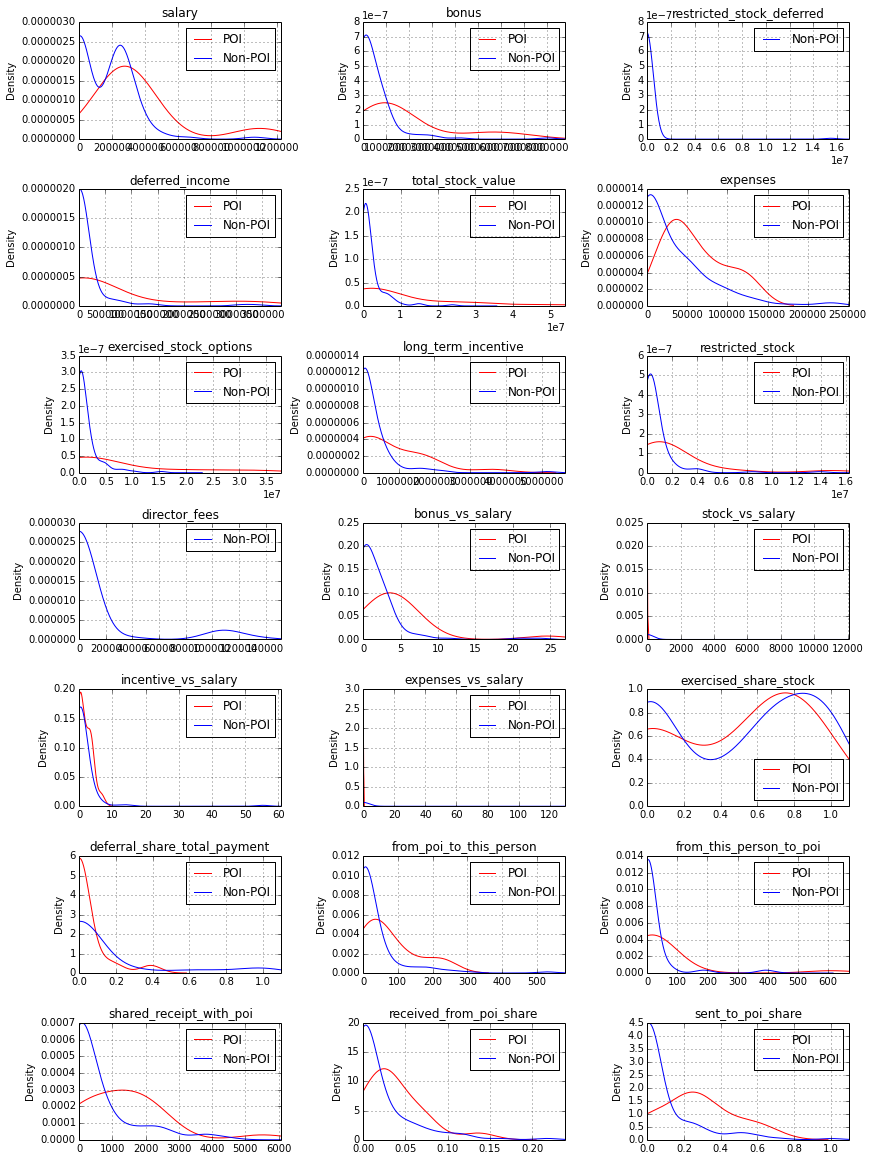

In [5]:
###Plot exploratory graphs
###Convert dictionary to dataframe
df = pd.DataFrame.from_dict(data_dict, orient='columns')
df = df.transpose()
###treat NaN as 0
df = df.replace('NaN',0)
### Deferred income is stored as negative values
df['deferred_income'] = [abs(v) for v in df['deferred_income']]
poi = df[(df.poi)]
non_poi = df[(df.poi == False)]

plt.figure(figsize=(len(features_list_all)/1.8, len(features_list_all)/1.2))
for i in range(1, len(features_list_all)):
    feature = features_list_all[i]
    #convert to float
    df[feature] = df[feature].astype(float)
    #Set up canvas with 3 graphs per row
    ax = plt.subplot2grid((len(features_list_all)/3+1,3), ((i-1)/3, (i-1)%3))
    #plot non-zero series 
    if max(poi[feature]) != 0:
        poi[feature].plot(kind='kde', label = 'POI', legend = True, color = 'red')
    if max(non_poi[feature]) != 0 :
        non_poi[feature].plot(kind='kde', label = 'Non-POI', legend = True, color = 'blue')
    ax.set_title("%s" % feature)
    ax.set_xlim((0, max(df[feature])*1.1))
plt.tight_layout()
plt.show()

In [6]:
###Remove irrelevant features
features_list_all.remove('director_fees')
features_list_all.remove('restricted_stock_deferred')

####Tree-based feature selection
Another way to select features relying on machine learning models is [tree-based selection](###http://scikit-learn.org/stable/auto_examples/ensemble/plot_forest_importances.html#example-ensemble-plot-forest-importances-py
). Feature importance is plotted below. The most important feature is 'expense' and the importance drops significantly after that. For sure 'expense' is in the game, but what else?

Based off results from both visualization and tree-based selection, I experimented with other features with importance above 0.06 for each testing classifier. Feature selection is such an important step (I will say even more important than picking classifer) to achieve the optimal results. In the beginning, I sorta relied on luck to find a combination of features that can yield the minimum 0.3 precision and recall scores. However, later inspired by the reviewer, I came up with a more systematic approach for selecting features. I tried adding features <i><b>individually</b></i> to 'expense' and <i><b>cummulatively</b></i>. The results show that 'expense' and 'bonus' form the best performing feature set for both Decision Trees and AdaBoost (the final selected) classifiers. For details how I reached this conclusion, please see section 3.1 'Pick an Algorithm.' 

Feature imporances
[ 0.02  0.06  0.06  0.1   0.2   0.06  0.02  0.04  0.02  0.08  0.04  0.08
  0.06  0.    0.02  0.02  0.04  0.02  0.06]
Feature ranking:
1. feature 4, expenses: (0.200000)
2. feature 3, total_stock_value: (0.100000)
3. feature 9, stock_vs_salary: (0.080000)
4. feature 11, expenses_vs_salary: (0.080000)
5. feature 1, bonus: (0.060000)
6. feature 2, deferred_income: (0.060000)
7. feature 5, exercised_stock_options: (0.060000)
8. feature 18, sent_to_poi_share: (0.060000)
9. feature 12, exercised_share_stock: (0.060000)
10. feature 10, incentive_vs_salary: (0.040000)
11. feature 7, restricted_stock: (0.040000)
12. feature 16, shared_receipt_with_poi: (0.040000)
13. feature 17, received_from_poi_share: (0.020000)
14. feature 8, bonus_vs_salary: (0.020000)
15. feature 6, long_term_incentive: (0.020000)
16. feature 14, from_poi_to_this_person: (0.020000)
17. feature 15, from_this_person_to_poi: (0.020000)
18. feature 0, salary: (0.020000)
19. feature 13, deferral_share_total_p

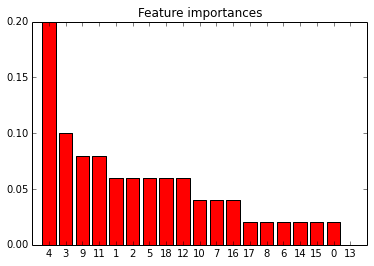

In [7]:
###Split features and labels
data_all = featureFormat(data_dict, features_list_all) 
labels_all, features_all = targetFeatureSplit(data_all)

### Compute the feature importances
clf_f = AdaBoostClassifier(random_state=202)
clf_f.fit(features_all, labels_all)
importances = clf_f.feature_importances_
print("Feature imporances")
print(importances)

indices = np.argsort(importances)[::-1]
number_features = len(features_list_all)-1

#### Print the feature ranking
print("Feature ranking:")
for f in range(number_features):
    indice = indices[f]
    print("%d. feature %d, %s: (%f)" % (f + 1, indice, features_list_all[1:][indice], importances[indice]))

#### Plot the feature importances of the forest
plt.figure()
plt.title("Feature importances")
plt.bar(range(number_features), importances[indices],
        color="r",
        align="center")
plt.xticks(range(number_features), indices)
plt.xlim([-1, number_features])
plt.show()

###2.3 Feature scaling
For the final features, I used [min-max](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.MinMaxScaler.html) to scale features as it's required for [K-Neighbours](http://stats.stackexchange.com/questions/121886/when-should-i-apply-feature-scaling-for-my-data) and [Support Vector Machine](http://stackoverflow.com/questions/15436367/svm-scaling-input-values). For Logistics regression, feature scaling is [not required but recommended](http://stats.stackexchange.com/questions/48360/is-standardization-needed-before-fitting-logistic-regression). For the tree-based classifiers, feature scaling doesn't matter and nor will it alter results even if I use the scaled features. 

In [8]:
###Scale features
min_max_scaler = preprocessing.MinMaxScaler()
for feature in features_list_all[1:]:
    df[feature] = min_max_scaler.fit_transform(df[feature].astype(float))
my_dataset = df.T.to_dict('dict')

##3. Pick and Tune an Algorithm
###3.1 Pick an algorithm
For the first taste, I tried Logistics Regression, Naives Bayes, Support Vector Machine, Decision Trees, and Adaboost.  Adapting the <code>tester.py</code> codes, I used precision score and recall score to select the model. These two metrics measures the percentage of true positive identified from a certain population. The higher the scores are, the better the model is. Given our small sample size, <code>tester.py</code> used [StratifiedShuffleSplit](http://scikit-learn.org/stable/modules/generated/sklearn.cross_validation.StratifiedShuffleSplit.html) for cross-valdiate the models. It randomly splits dataset to train and test sets on a 9-1 ratio (default setting  test_size=0.1) while perserving the proportion of POI and non-POI samples. It returns averaged scores over 1000 iterations for us to choose from. 

As explained in section 'Tree-based feature selection', I experimented two ways with different feature sets and classifiers:
* Adding 'total_stock_value','stock_vs_salary','expenses_vs_salary','bonus', 'deferred_income', 'exercised_stock_options' <i><b>individually</b></i> to 'expense'. The results are the current output shown below. I also plot the precision score and recall score under this experiment below so it's easier to see the model performance. Among all the combinations, AdaBoost with 'expense' and 'bonus' shows the highest precision(0.52) and recall score (0.44) to start with.
* Adding the above six features <i><b>cummulatively</b></i> in the order of feature importance from tree-based selection to 'expense'. To see the results under this experiment, just place the "`features_list features_list =['poi','expenses',] `" code before the for-loop "`for f in features_temp`." Just a heads-up that it takes quite a bit  time to run and the results are not as good as the first method above.

So finally, I decided to proceed with Adaboost and only two features, expense and bonus.

In [9]:
### Create classifiers
lr = LogisticRegression()
gnb = GaussianNB()
svc = LinearSVC()
kn = KNeighborsClassifier()
dt =  DecisionTreeClassifier()
adb = AdaBoostClassifier()

models = [(lr, 'Logistic'),
          (gnb, 'Naive Bayes'),
          (svc, 'Support Vector Classification'),
          (kn, 'K-Neighbors'),
          (dt, 'Decision Tree'),
          (adb, 'AdaBoost'),
          ]

Logistic
['NaN', 'NaN', 'NaN', 'NaN', 'NaN', 'NaN']
['NaN', 'NaN', 'NaN', 'NaN', 'NaN', 'NaN']
Naive Bayes
[0.5966101694915255, 0.17842454919329326, 0.19748872363769351, 0.5496598639455782, 0.6106750392464678, 0.592173017507724]
[0.264, 0.846, 0.81, 0.202, 0.1945, 0.2875]
Support Vector Classification
[0.889344262295082, 0.0, 'NaN', 0.5122950819672131, 0.1380952380952381, 1.0]
[0.1085, 0.0, 'NaN', 0.0625, 0.0145, 0.114]
K-Neighbors
[0.3869047619047619, 0.010484927916120577, 0.008141112618724558, 0.366412213740458, 0.36662606577344703, 0.2929936305732484]
[0.1625, 0.004, 0.003, 0.144, 0.1505, 0.092]
Decision Tree
[0.3223787167449139, 0.23040254237288135, 0.23974915581283165, 0.39844108207244383, 0.3495717344753747, 0.2821497120921305]
[0.309, 0.2175, 0.2485, 0.4345, 0.3265, 0.294]
AdaBoost
[0.4170783345095272, 0.2646276595744681, 0.1693121693121693, 0.5191514437242192, 0.37844408427876824, 0.4329896907216495]
[0.2955, 0.199, 0.128, 0.4405, 0.2335, 0.336]


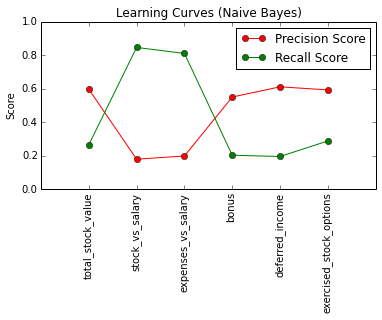

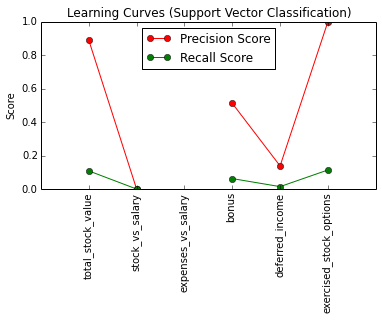

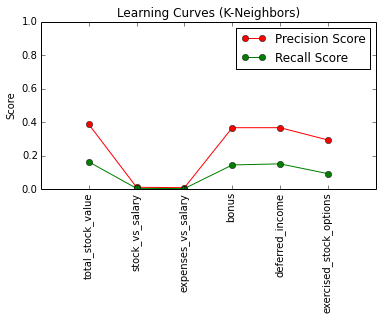

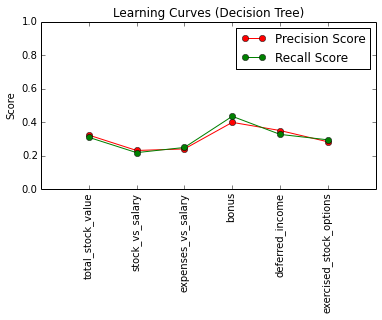

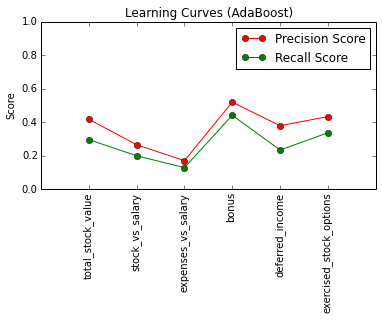

In [10]:
### Features to be tested with expense
features_temp = ['total_stock_value',
                'stock_vs_salary',
                'expenses_vs_salary',
                'bonus', 
                'deferred_income', 
                'exercised_stock_options',]

### Test classifiers
PERF_FORMAT_STRING = "\
\tPrecision: {:>0.{display_precision}f}\t\
Recall: {:>0.{display_precision}f}"    

def try_classifier(clf):
    precision_score = []
    recall_score = []
    ######################################################################
    ###To see performance of features added cumulatively,#################
    ###uncomoment here and ###############################################
    ###comment the same codes after for loop below #######################
    #features_list =['poi',
    #                'expenses', ]
    ######################################################################
    ### Iterate through all testing features
    for f in features_temp:
        features_list =['poi',   # See comment above
                        'expenses', ] # See comment above
        features_list.append(f)
        
        ### Extract features and labels from dataset for local testing
        data = featureFormat(my_dataset, features_list, sort_keys = True)
        labels, features = targetFeatureSplit(data)
        ### Convert labels to integer
        labels = map(int, labels)

        folds = 1000
        cv = StratifiedShuffleSplit(labels, folds, random_state = 42)
        true_negatives = 0
        false_negatives = 0
        true_positives = 0
        false_positives = 0

        #iterate through all classifers
        for train_idx, test_idx in cv: 
            features_train = []
            features_test  = []
            labels_train   = []
            labels_test    = []
            for ii in train_idx:
                features_train.append( features[ii] )
                labels_train.append( labels[ii] )
            for jj in test_idx:
                features_test.append( features[jj] )
                labels_test.append( labels[jj] )

            ### fit the classifier using training set, and test on test set
            clf.fit(features_train, labels_train)
            predictions = clf.predict(features_test)
            for prediction, truth in zip(predictions, labels_test):
                if prediction == 0 and truth == 0:
                    true_negatives += 1
                elif prediction == 0 and truth == 1:
                    false_negatives += 1
                elif prediction == 1 and truth == 0:
                    false_positives += 1
                else:
                    true_positives += 1
        try:
            precision = 1.0*true_positives/(true_positives+false_positives)
            recall = 1.0*true_positives/(true_positives+false_negatives)
            precision_score.append(precision)
            recall_score.append(recall)
        except:
            precision_score.append('NaN')
            recall_score.append('NaN')
    print(name) 
    print(precision_score) 
    print(recall_score)
    return name, precision_score, recall_score

###Plot learning curves
number_features = range(1, len(features_temp)+1)
def plot_learning_curve(title):
    fig = plt.figure()
    fig.set_size_inches(6,3)
    ax = fig.add_subplot(111)
    ax.set_xlim(0,len(features_temp)+1)
    ax.set_ylim(0,1)
    ax.set_title(title)
    
    ax.set_ylabel("Score")
    line1 = ax.plot(number_features, precision_score, 'o-', color="r",
             label="Precision Score")
    line2 = ax.plot(number_features, recall_score, 'o-', color="g",
             label="Recall Score")
    ax.set_xticks(number_features)
    ax.set_xticklabels(features_temp, rotation='vertical')
    ax.legend(loc="best")
    return plt
 
###iterate through all the models
for clf, name in models:
    ###returns list of precision and recall score
    estimator, precision_score, recall_score = try_classifier(clf)
    if name == 'Logistic': ##skip logistics due to all NaN values
        None
    else:
        ###plot precison and recall score
        title = "Learning Curves (%s)" %name
        plot_learning_curve(title)

###3.2 Tune Parameters
Parameter-tuning a necessary step to optimize models. Every classifier offers a variety of parameters but fits the train set with default parameters. Trying a few other parameters will likely help me find better ones and improve models. It's like buying a bike. Buying one straight out from the bike store can surely get you on the road. But if you want to bike in different weather conditions and terrains, you need to customize parts, e.g. changing tires or purchasing special visors.

To make sure the results are consistent between <code>tester.py</code> and this section, I used <code>tester.py</code> to tune up [n_estimator and learning rate for Adaboost](http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.AdaBoostClassifier.html) and choose the one with the best precision score and recall score. For n_estimator, I tested different values between 10 and 1000; For learning rate, I tested between 0.1 to 2.0. The results are below: `n_estimators = 250` and `learning_rate = 0.1`, which gives 0.62 for precision score and 0.43 for recall score. The precision score is 0.1 higher than that(0.52) under default setting (`n_estimators = 50` and `learning_rate = 1.0`) though the recall score is losing a tiny 0.01 to the latter (0.44). Therefore, I think `n_estimators = 250` and `learning_rate = 0.1` is the best parameter combination.

In [11]:
###Tune parameters
features_list =['poi',
                'expenses', 
                'bonus']
n_estimators = [10, 50, 100, 250, 1000]
learning_rate = [0.1, 1.0, 1.5, 2.0]

### Iterate through all parameters
for i in range(len(n_estimators)):
    for j in range(len(learning_rate)):
        clf = AdaBoostClassifier(n_estimators = n_estimators[i], learning_rate = learning_rate[j])
        test_classifier(clf, my_dataset, features_list, folds = 1000)

AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None,
          learning_rate=0.1, n_estimators=10, random_state=None)
	Accuracy: 0.80273	Precision: 0.17557	Recall: 0.02300	F1: 0.04067	F2: 0.02784
	Total predictions: 11000	True positives:   46	False positives:  216	False negatives: 1954	True negatives: 8784

AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None,
          learning_rate=1.0, n_estimators=10, random_state=None)
	Accuracy: 0.84255	Precision: 0.59504	Recall: 0.41950	F1: 0.49208	F2: 0.44580
	Total predictions: 11000	True positives:  839	False positives:  571	False negatives: 1161	True negatives: 8429

AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None,
          learning_rate=1.5, n_estimators=10, random_state=None)
	Accuracy: 0.81691	Precision: 0.49433	Recall: 0.30500	F1: 0.37724	F2: 0.33030
	Total predictions: 11000	True positives:  610	False positives:  624	False negatives: 1390	True negatives: 8376

AdaBoostClassifier(algorithm='SAMME.R', base_esti

###3.3 Validation 
One common mistake of building a model is to overfit the existing data. In simple words, the machine is trying so much to mimick the pattern of a certain form of dataset that it misses the big, true picture. Therefore, we need to split data into a development(training) set and an evaluation(testing) and compute the performance metrics for selecting the best parameters. AdaBoost with 250 n_estimators and 0.1 learnings rate appear to be my best model. The cross-validation results shown, again, below: 

In [12]:
clf = AdaBoostClassifier(n_estimators = 250, learning_rate = 0.1)
test_classifier(clf, my_dataset, features_list, folds = 1000)

AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None,
          learning_rate=0.1, n_estimators=250, random_state=None)
	Accuracy: 0.84845	Precision: 0.61901	Recall: 0.43300	F1: 0.50956	F2: 0.46069
	Total predictions: 11000	True positives:  866	False positives:  533	False negatives: 1134	True negatives: 8467



###3.4 Evaluation Metrics

One commonly-used metric is accuracy score, which measures the proportion of true results (both positive and negative) among the entire sample. For this project, the classifer's ability to identify POI is more important. Therefore, the evaluation metricss I used throughout this project are in favor of precision score and recall score.
####Precision
The presision score measures the classifier's ability [not to label negative sample as positve](http://scikit-learn.org/stable/modules/generated/sklearn.metrics.precision_score.html). It's easier to grasp the idea that the better the classifer predicts the true POIs, the better the score it would be. However, if the classifer mis-predicts many non-POIs as POIs, for example, to redflag 'Metts Mark' as a suspicious POI even though he is not, it would lower the precision score. If the strategy is to redflag as many potential POIs as possible, you may have higher tolerance of the classifer mislabelling non-POIs (therefore accept a lower precision score), just to be risk-averse. My classifer achieved 0.62 average precision scores for 1000 cross-validated folds of dataset. It means that of the 5 likely POIs that my model predicts, 3 are truly POI. 

####Recall
The recall score measures the classifier's ability to [identify all the positive samples](http://scikit-learn.org/stable/modules/generated/sklearn.metrics.recall_score.html). If the classifer fails to label, say, 'SHELBY REX' as a POI, it will potentially lower the recall score. My model gets 0.43 on average for the recall socre, which is substantially lower than precision and indicates room for improvement. Nevertheless, with a recall score of 0.43, it means that for every 100 true POIs, 43 will be flagged as POI. 

In [13]:
### Dump the classifier, dataset, and features_list 
dump_classifier_and_data(clf, my_dataset, features_list)

##Conclusions & Reflections
This project explored Enron dataset and developed an AdaBoost model for identifying and predicting POIs. Using 1000-fold cross-validations, this model returns a precision score of 0.62 and a recall score of 0.43. The model may be further improved by adding more information. It's challenging to work with a dataset of ~140 records and 18 POIs. Actually, the <code>poi_names.txt</code> contains 35 names from [this post](http://usatoday30.usatoday.com/money/industries/energy/2005-12-28-enron-participants_x.htm). However, many are missing financial information from the <code>enron61702insiderpay.pdf</code>. It will be great if we can ferret out information for them, which will nearly double the number of POIs.

Also, the email features look interesting and reveal moderate difference between POI and non-POI groups but didn't really help the model at the end. One area of improvement is to construct additional email features, for example, frequency of key words from email messages. 
